In [19]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import scipy.stats as stats
from stochastic_search import StochasticSearch

/export/raid1/home/ojeda040/miniconda3/envs/SS_UC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# folder   = "SCS VD PCA LR 10:250:5 0.6 Exp3 AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.3 Exp2 AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.4 Exp AE"
# #log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_57.csv"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_57_test.csv"
# #log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.6 Exp3 AE NA"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_54.csv"
# #log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# Used in CCN
# folder   = "SCS UC 10:250:5 0.6 Exp3 AE Fixed copy"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_60.csv"

# Test

folder   = "SCS UC LD topn 6:100:4 Dual Guided clip_iter 18"
log_path = "/export/raid1/home/kneel027/Second-Sight/logs/subject1/" + folder + "/statistics_df_20.csv"

df = pd.read_csv(log_path)
df.head(28)

# Sample Indicator: 
    #   0 --> Ground Truth
    #   1 --> Ground Truth CLIP
    #   2 --> Decoded CLIP Only
    #   3 --> Library Reconstruction
    #   4 --> Search Reconstruction


,Unnamed: 0,ID,Iter,Sample Indicator,Strength,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,Brain Correlation V4,Brain Correlation Early Visual,Brain Correlation Higher Visual,Brain Correlation Unmasked,SSIM,Pixel Correlation,CLIP Pearson,CLIP Two-way
0,0,0,0.0,NaN,1.0000,0.566628,0.671265,0.749916,0.814922,0.687453,0.833198,0.801403,0.074288,0.068293,0.779130,1.000000
1,1,0,1.0,4.0,0.9994,0.582428,0.737064,0.803598,0.835611,0.733594,0.846826,0.836125,0.058712,0.024016,0.750683,1.000000
2,2,0,2.0,NaN,0.9952,0.563202,0.703567,0.773915,0.838445,0.706630,0.871431,0.820644,0.063085,-0.021270,0.786445,1.000000
3,3,0,3.0,NaN,0.9838,0.628477,0.734296,0.706890,0.799648,0.725473,0.819578,0.819059,0.062124,0.067252,0.744809,1.000000
4,4,0,4.0,NaN,0.9616,0.601772,0.644896,0.693662,0.771220,0.684352,0.825437,0.786656,0.066738,-0.050887,0.748557,1.000000
5,5,0,5.0,NaN,0.9250,0.676062,0.712684,0.781638,0.806125,0.746009,0.884007,0.840713,0.057158,-0.092310,0.795534,1.000000
6,6,0,NaN,3.0,NaN,0.729270,0.788476,0.758892,0.791367,0.773344,0.787293,0.828075,0.106690,0.119462,0.612225,1.000000
7,7,0,NaN,2.0,NaN,0.396290,0.451819,0.473052,0.745089,0.492320,0.832305,0.672506,0.063305,0.005034,0.763635,1.000000
8,8,0,NaN,1.0,NaN,0.302909,0.040780,0.090449,0.478036,0.236185,0.752931,0.446481,0.105220,0.175468,NaN,NaN
9,9,0,NaN,0.0,0.9250,0.822044,0.733438,0.661992,0.843715,0.791381,0.796184,0.829140,NaN,NaN,1.000000,1.000000


In [4]:
# Statistical Analysis

# ------------------------------------------ Quantitative Measures -----------------------------
#     Methods       |  PixCorr |  SSIM  |  CLIP |
#                   |          |        |       |          
#  Takagi et al.    |          |        | 77.0% |
#  Stable Diffusion |   .150   |  .325  |       |
#  Brain-Diffuser   |   .254   |  .356  | 91.5% |

# Final Sample Mean SSIM:  0.24619865488800002
# Final Sample Mean Pixel Correlation:  0.18779825951199997
# Final Sample Mean CLIP Pearson:  0.6848930502039999
# Final Sample Mean CLIP Two-way:  0.9188355520279999


print("------------------------------------------------ Search Reconstruction -----------------------------------------------------------------\n")

df_final_samples = df.loc[(df['Sample Indicator'] == 4.0)]

print("Final Sample Mean SSIM Search Reconstruction: ", df_final_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Search Reconstruction: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("Final Sample Mean Pixel Correlation Search Reconstruction: ", df_final_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Search Reconstruction: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("Final Sample Mean CLIP Pearson Search Reconstruction: ", df_final_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Search Reconstruction: ", df_final_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only: ", ((df_final_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(1200)))

print("------------------------------------------------ Library Reconstruction -----------------------------------------------------------------\n")

df_library_samples = df.loc[(df['Sample Indicator'] == 3.0)]

print("Final Sample Mean SSIM Library Reconstruction: ", df_library_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Search Reconstruction: ", ((df_library_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("Final Sample Mean Pixel Correlation Library Reconstruction: ", df_library_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Library Reconstruction: ", ((df_library_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("Final Sample Mean CLIP Pearson Library Reconstruction: ", df_library_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Library Reconstruction: ", df_library_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Library Reconstruction : ", ((df_library_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("------------------------------------------------ Decoded CLIP Only -----------------------------------------------------------------\n")

df_decoded_samples = df.loc[(df['Sample Indicator'] == 2.0)]

print("Final Sample Mean SSIM Decoded CLIP Only: ", df_decoded_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Decoded CLIP Only: ", ((df_decoded_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

print("Final Sample Mean Pixel Correlation Decoded CLIP Only: ", df_decoded_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Decoded CLIP Only: ", ((df_decoded_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

print("Final Sample Mean CLIP Pearson Decoded CLIP Only: ", df_decoded_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Decoded CLIP Only: ", df_decoded_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only: ", ((df_decoded_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

------------------------------------------------ Search Reconstruction -----------------------------------------------------------------

Final Sample Mean SSIM Search Reconstruction:  0.26535322609
Final Sample Confidence Interval SSIM Search Reconstruction:  0.07518331552694596
Final Sample Mean Pixel Correlation Search Reconstruction:  0.21862535519999998
Final Sample Confidence Interval Pixel Correlation Search Reconstruction:  0.11009191143167726
Final Sample Mean CLIP Pearson Search Reconstruction:  0.686138264835
Final Sample Mean CLIP Two-way Search Reconstruction:  0.9666985362749999
Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only:  0.006053623289244032
------------------------------------------------ Library Reconstruction -----------------------------------------------------------------

Final Sample Mean SSIM Library Reconstruction:  0.24890631353499998
Final Sample Confidence Interval SSIM Search Reconstruction:  0.06953823413432234
Final Sample Mean Pixel 

0.8877793


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation')

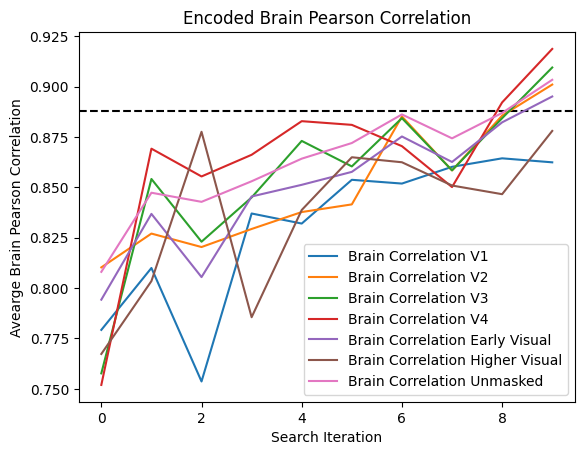

In [14]:
# Average Iteration Brain Region Plot
print(df.loc[(df['Sample Indicator'] == 0.0)])

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    

plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), color = 'blue', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), color = 'green', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), color = 'red',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), color = 'orange',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), color = 'brown', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(),  color = 'magenta',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), color = 'black', linestyle = 'dashed', linewidth=1)

plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
plt.plot(brain_correlation_higher_visual, marker='.', color = 'brown', label = 'Higher Visual', linewidth=1)
plt.plot(brain_correlation_early_visual, marker='.',  color = 'magenta', label = 'Early Visual', linewidth=1)
plt.plot(brain_correlation_unmasked, marker='.',  color = 'black', label = 'Unmasked', linewidth=1)

plt.legend(fontsize = "xx-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation (1 to 0.6 stength with X^3) High Strength")
mpl.rcParams['figure.dpi'] = 300


Text(0.5, 1.0, 'Encoded Brain Pearson Correlation Unmasked')

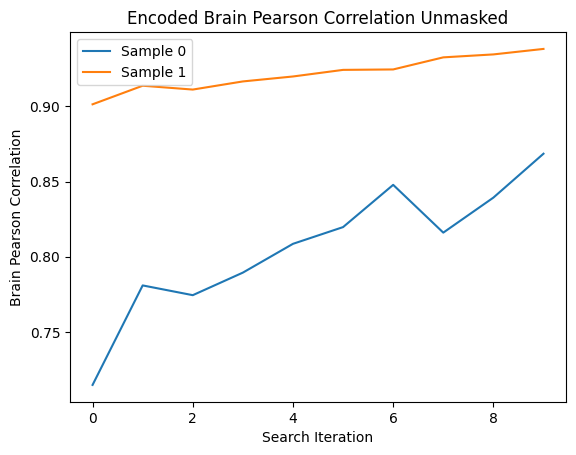

In [15]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

y_v1 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean()
y_v2 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean()
y_v3 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean()
y_v4 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean()
y_ev = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean()
y_hv = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean()
y_unmasked = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean()

v1_set = True
v2_set = True
v3_set = True
v4_set = True
ev_set = True
hv_set = True
unmasked_set = True

x_v1 = 0 
x_v2 = 0 
x_v3 = 0 
x_v4 = 0 
x_ev = 0 
x_hv = 0 
x_umasked = 0 

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    
    if(iteration_val_v1 > y_v1 and v1_set):
        x_v1 = iteration - 1
        v1_set = False
        
    if(iteration_val_v2 > y_v2 and v2_set):
        x_v2 = iteration - 1
        v2_set = False
        
    if(iteration_val_v3 > y_v3 and v3_set):
        x_v3 = iteration - 1
        v3_set = False
        
    if(iteration_val_v4 > y_v4 and v4_set):
        x_v4 = iteration - 1
        v4_set = False
        
    if(iteration_val_ev > y_ev and ev_set):
        x_ev = iteration - 1
        ev_set = False
        
    if(iteration_val_hv > y_hv and hv_set):
        x_hv = iteration - 1
        hv_set = False
        
    if(iteration_val_unmasked > y_unmasked and unmasked_set):
        x_unmasked = iteration - 1
        unmasked_set = False
    
# print(df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean())
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')


N = 10
x = np.array([0,1,2,3,4,5,6,7,8,9])
# y = np.array(brain_correlation_unmasked)
# a, b = np.polyfit(x, brain_correlation_unmasked, deg=1)
# y_est = a * x + b
# y_err = st.t.interval(alpha=0.95, df=len(y)-1, loc=np.mean(y), scale=st.sem(y))
# print(y_err[0])
# print(y_err[1])

y_un = np.array(brain_correlation_unmasked)
ci_un = 0.95 * np.std(y_un) / math.sqrt(N)

# y_hi = np.array(brain_correlation_higher_visual)
# ci_hi = 0.95 * np.std(y_hi) / math.sqrt(N)

# y_er = np.array(brain_correlation_early_visual)
# ci_er = 0.95 * np.std(y_er) / math.sqrt(N)

# y_vo = np.array(brain_correlation_V1)
# ci_vo = 0.95 * np.std(y_vo) / math.sqrt(N)

# y_vt = np.array(brain_correlation_V2)
# ci_vt = 0.95 * np.std(y_vt) / math.sqrt(N)

# y_vth = np.array(brain_correlation_V3)
# ci_vth = 0.95 * np.std(y_vth) / math.sqrt(N)

# y_vf = np.array(brain_correlation_V4)
# ci_vf = 0.95 * np.std(y_vf) / math.sqrt(N)

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

# mean, lower, upper = [],[],[]
# ci = 0.95

# m, ml, mu = mean_confidence_interval(y, ci)
# mean.append(m)
# lower.append(ml)
# upper.append(mu)


plt.plot(brain_correlation_V1, marker='.', label = 'V1', linewidth=1, color = "royalblue")
plt.plot(brain_correlation_V2, marker='.', label = 'V2', linewidth=1, color = "darkviolet")
plt.plot(brain_correlation_V3, marker='.', label = 'V3', linewidth=1, color = "violet")
plt.plot(brain_correlation_V4, marker='.', label = 'V4', linewidth=1, color = "forestgreen")
plt.plot(brain_correlation_early_visual, marker='.', label = 'Early Visual', linewidth=1, color = "red")
plt.plot(brain_correlation_higher_visual, marker='.', label = 'Higher Visual', linewidth=1, color = "darkorange")
plt.plot(brain_correlation_unmasked, marker='.', label = 'NSD General', linewidth=1, color = "black")
# plt.fill_between(x, y_err[0], y_err[0], color='dimgray', alpha=0.2)
# plt.fill_between(x, upper, lower, color='dimgray', alpha=0.2)
plt.fill_between(x, (y_un-ci_un), (y_un+ci_un), color='black', alpha=.2)
# plt.fill_between(x, (y_hi-ci_hi), (y_hi+ci_hi), color='darkorange', alpha=.2)
# plt.fill_between(x, (y_er-ci_er), (y_er+ci_er), color='red', alpha=.2)
# plt.fill_between(x, (y_vo-ci_vo), (y_vo+ci_vo), color='royalblue', alpha=.2)
# plt.fill_between(x, (y_vt-ci_vt), (y_vt+ci_vt), color='darkviolet', alpha=.2)
# plt.fill_between(x, (y_vth-ci_vth), (y_vth+ci_vth), color='violet', alpha=.2)
# plt.fill_between(x, (y_vf-ci_vf), (y_vf+ci_vf), color='forestgreen', alpha=.2)

plt.plot([8, 8 + 1], [y_v1, y_v1] , color = "royalblue", linestyle="dashed", linewidth=2)
plt.plot([x_v2, x_v2 + 0.85], [y_v2, y_v2] , color = "darkviolet", linestyle="dashed", linewidth=2)
plt.plot([x_v3, x_v3 + 0.85], [y_v3, y_v3] , color = "violet", linestyle="dashed", linewidth=2)
plt.plot([x_v4 - 0.10, x_v4 + 0.65], [y_v4, y_v4] , color = 'forestgreen', linestyle="dashed", linewidth=2)
plt.plot([x_ev, x_ev + 0.85], [y_ev - 0.002, y_ev - 0.002] , color = 'red', linestyle="dashed", linewidth=2)
plt.plot([0, 0 + 0.85], [y_hv, y_hv] , color = "darkorange", linestyle="dashed", linewidth=2)
plt.plot([x_unmasked, x_unmasked + 0.85], [y_unmasked, y_unmasked] , color = 'black', linestyle="dashed", linewidth=2, label="Ground Truth Image")
#plt.axhline(x = [1,3], y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
leg = plt.legend(loc="upper left", ncol = 2, fontsize = "xx-small")
leg.legendHandles[7].set_color('silver')
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 300


In [ ]:
# Search iterations to Ground Truth

x_iter_values = []

x_iter_values.append(9)
x_iter_values.append(x_v2)
x_iter_values.append(x_v3)
x_iter_values.append(x_v4)
x_iter_values.append(0)

x_labels = ['V1', 'V2', 'V3', 'V4', 'Higher Visual']

# x_iter_values.append(0)
# x_iter_values.append(x_v4)
# x_iter_values.append(x_v3)
# x_iter_values.append(x_v2)
# x_iter_values.append(9)

# x_labels = ['Higher Visual', 'V4', 'V3', 'V2', 'V1']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_labels, x_iter_values, marker='o', linewidth=2, color = "darkgray")

plt.xlabel("Brain Areas", fontsize=18)
plt.ylabel("Iterations to ground truth", fontsize=18)
plt.title("Search iterations to surpass ground truth\n brain correlation score", fontsize=20)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'

In [ ]:
# Single Iteration Brain Region Plot

sample_0 = []
sample_1 = []
sample_2 = []
sample_3 = []
sample_4 = []
sample_5 = []
sample_6 = []
sample_7 = []
sample_8 = []
sample_9 = []

for iteration in range(10):
    sample_0.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 0)]['Brain Correlation Unmasked'])
    sample_1.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 1)]['Brain Correlation Unmasked'])
    sample_2.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 2)]['Brain Correlation Unmasked'])
    sample_3.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 3)]['Brain Correlation Unmasked'])
    sample_4.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 4)]['Brain Correlation Unmasked'])
    sample_5.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 5)]['Brain Correlation Unmasked'])
    sample_6.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 6)]['Brain Correlation Unmasked'])
    sample_7.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 7)]['Brain Correlation Unmasked'])
    sample_8.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 8)]['Brain Correlation Unmasked'])
    sample_9.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 9)]['Brain Correlation Unmasked'])


plt.plot(sample_0, label = 'Sample 0')
plt.plot(sample_1, label = 'Sample 1')
plt.plot(sample_2, label = 'Sample 2')
plt.plot(sample_3, label = 'Sample 3')
plt.plot(sample_4, label = 'Sample 4')
plt.plot(sample_5, label = 'Sample 5')
plt.plot(sample_6, label = 'Sample 6')
plt.plot(sample_7, label = 'Sample 7')
plt.plot(sample_8, label = 'Sample 8')
plt.plot(sample_9, label = 'Sample 9')
plt.legend(fontsize = "x-small")
plt.xlabel("Search Iteration")
plt.ylabel("Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation Unmasked")

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


/export/raid1/home/ojeda040/Second-Sight


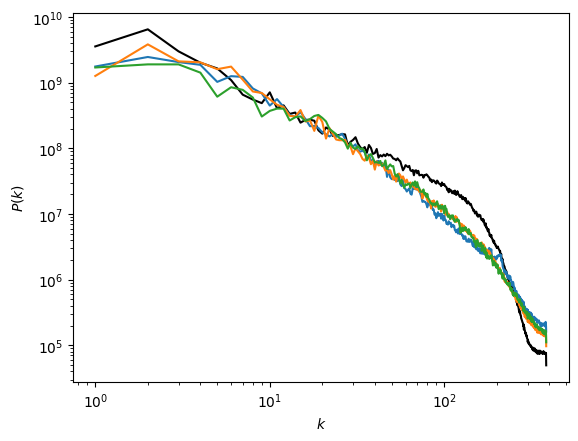

In [31]:
# Fourier Transform of Images
import matplotlib.pyplot as plt
import torch.nn as nn
print(os.getcwd())

os.chdir("/export/raid1/home/ojeda040/Second-Sight")

subject = 1
folder = "SCS UC LD 6:100:4 Dual Guided clip_iter 40"
image = "Ground Truth"

path_distribution            = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/distribution_0/"
path = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/0/" + image + ".png"
path_grayscale    = "/home/naxos2-raid25/ojeda040/local/ojeda040/Second-Sight/reconstructions/subject" + str(subject) + "/" + folder + "/" + "0/" + image + "Grayscale.png"

# Generate images 
SCS = StochasticSearch(modelParams=["gnetEncoder", "clipEncoder"],
                           device="cuda:0",
                           n_iter=6,
                           n_samples=100,
                           n_branches=4,
                           ae=True)


#SCS.generate_image_distribution(folder,0,0,10)

def convert_images_grayscale(path): 
    
    # Convert the image to grayscale
    img_rgb = Image.open(path)
    img_gray = img_rgb.convert('L')
    img_gray.save(path)

def create_power_spectrum(path):

    # Create a numpy array of the image.
    image = mpimg.imread(path)

    npix = image.shape[0]

    # Fourier transform of two dimensional image data array
    fourier_image = np.fft.fftn(image)

    # The Fourier image array now contains the complex valued amplitudes of all the Fourier components. 
    # Only require the square of the amplitudes to compute the variances.
    fourier_amplitudes = np.abs(fourier_image)**2

    # Automatically return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
    kfreq = np.fft.fftfreq(npix) * npix

    # Convert this to a two dimensional array matching the layout of the two dimensional Fourier image
    kfreq2D = np.meshgrid(kfreq, kfreq)

    # Interested in the actual wave vectors, but rather in their norm
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    # No longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    # To bin the amplitudes in k space, we need to set up wave number bins.
    kbins = np.arange(0.5, npix//2+1, 1.)

    # The kbin array will contain the start and end points of all bins; the corresponding  k values are the midpoints of these bins
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    # To compute the average Fourier amplitude (squared) in each bin
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)

    # Remember that we want the total variance within each bin. Right now, we only have the average power.
    # To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    return kvals, Abins

# Ground Truth Line
convert_images_grayscale(path)
kvals_ground_truth, Abins_ground_truth = create_power_spectrum(path)

kvals = []
Abins = []
for i in range(10):
    
    current_path = path_distribution + str(i) + ".png"
    convert_images_grayscale(current_path)
    kval, Abin = create_power_spectrum(current_path)
    kvals.append(kval)
    Abins.append(Abin)
    

plt.loglog(kvals_ground_truth, Abins_ground_truth, color = "black")
plt.loglog(kvals[0], Abins[0])
plt.loglog(kvals[1], Abins[1])
plt.loglog(kvals[2], Abins[2])
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.show()

criterion = nn.MSELoss()

# plt.imshow(image)
# plt.show()


